In [1]:
%matplotlib inline
from Pathopticon_master_v2 import *
import pandas as pd
import pickle
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram, set_link_color_palette
from scipy.spatial import distance
import scipy.stats as st
from matplotlib.cm import get_cmap
from matplotlib import gridspec, colors
from matplotlib.patches import Rectangle
import random
import functools
from itertools import product
import statsmodels.api as sm

## Set file paths

In [2]:
proj_path = '/Users/ardahalu/Research/CICS/L1000_project/Pathopticon_all_analyses_v2/'

proj_R_path = proj_path + 'Pathopticon_for_R/'
proj_reducibility_path = proj_path + 'Pathopticon_reducibility/'
proj_invitro_path = proj_path + 'Pathopticon_invitro_data/'


proj_external_data_path = proj_path + 'Pathopticon_external_data/'
proj_intermediary_outputs_path = proj_path + 'Pathopticon_intermediary_outputs/'
proj_output_path = proj_path + 'Pathopticon_all_analyses_outputs/'

input_paths_dict = input_paths(proj_path)

In [3]:
rev_feather_path = '/Volumes/Partition1/REV_feather_files/'

## Import L1000 metadata

In [4]:
L1000_gene_info, L1000_cell_info, L1000_inst_info, L1000_pert_info, L1000_sig_info = import_L1000_metadata(input_paths_dict['L1000_gene_info_path'], 
                                                                                                           input_paths_dict['L1000_cell_info_path'],
                                                                                                           input_paths_dict['L1000_inst_info_path'], 
                                                                                                           input_paths_dict['L1000_pert_info_path'], 
                                                                                                           input_paths_dict['L1000_sig_info_path'])

## Import cell type-specific QUIZ-C networks

In [5]:
QUIZC_edgelist_df_dict, QUIZC_nodelist_df_dict, QUIZC_allcells, \
QUIZC_allgenes, QUIZC_alldrugs, QUIZC_allnodes = process_QUIZC_output(proj_path + 'ALL_QUIZC75/' + 'ALL_cell_pos_edges_dict_0.75.pickle', 
                                                                     proj_path + 'ALL_QUIZC75/' + 'ALL_cell_neg_edges_dict_0.75.pickle',
                                                                     proj_path + 'ALL_QUIZC75/' + 'ALL_cell_drugs_dict_0.75.pickle',
                                                                     L1000_gene_info)

100%|██████████| 71/71 [00:07<00:00,  9.79it/s]


## Level 4 ZS distributions (Supp. Figs. 1A-B)

 28%|██▊       | 17/60 [1:29:21<3:38:54, 305.46s/it]/Users/ardahalu/anaconda3/envs/py3_main/lib/python3.8/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/ardahalu/anaconda3/envs/py3_main/lib/python3.8/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/ardahalu/anaconda3/envs/py3_main/lib/python3.8/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/ardahalu/anaconda3/envs/py3_main/lib/python3.8/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/ardahalu/anaconda3/envs/py3_main/lib/python3.8/site-packages/seaborn/distributions.py:288: UserWarning: Data must

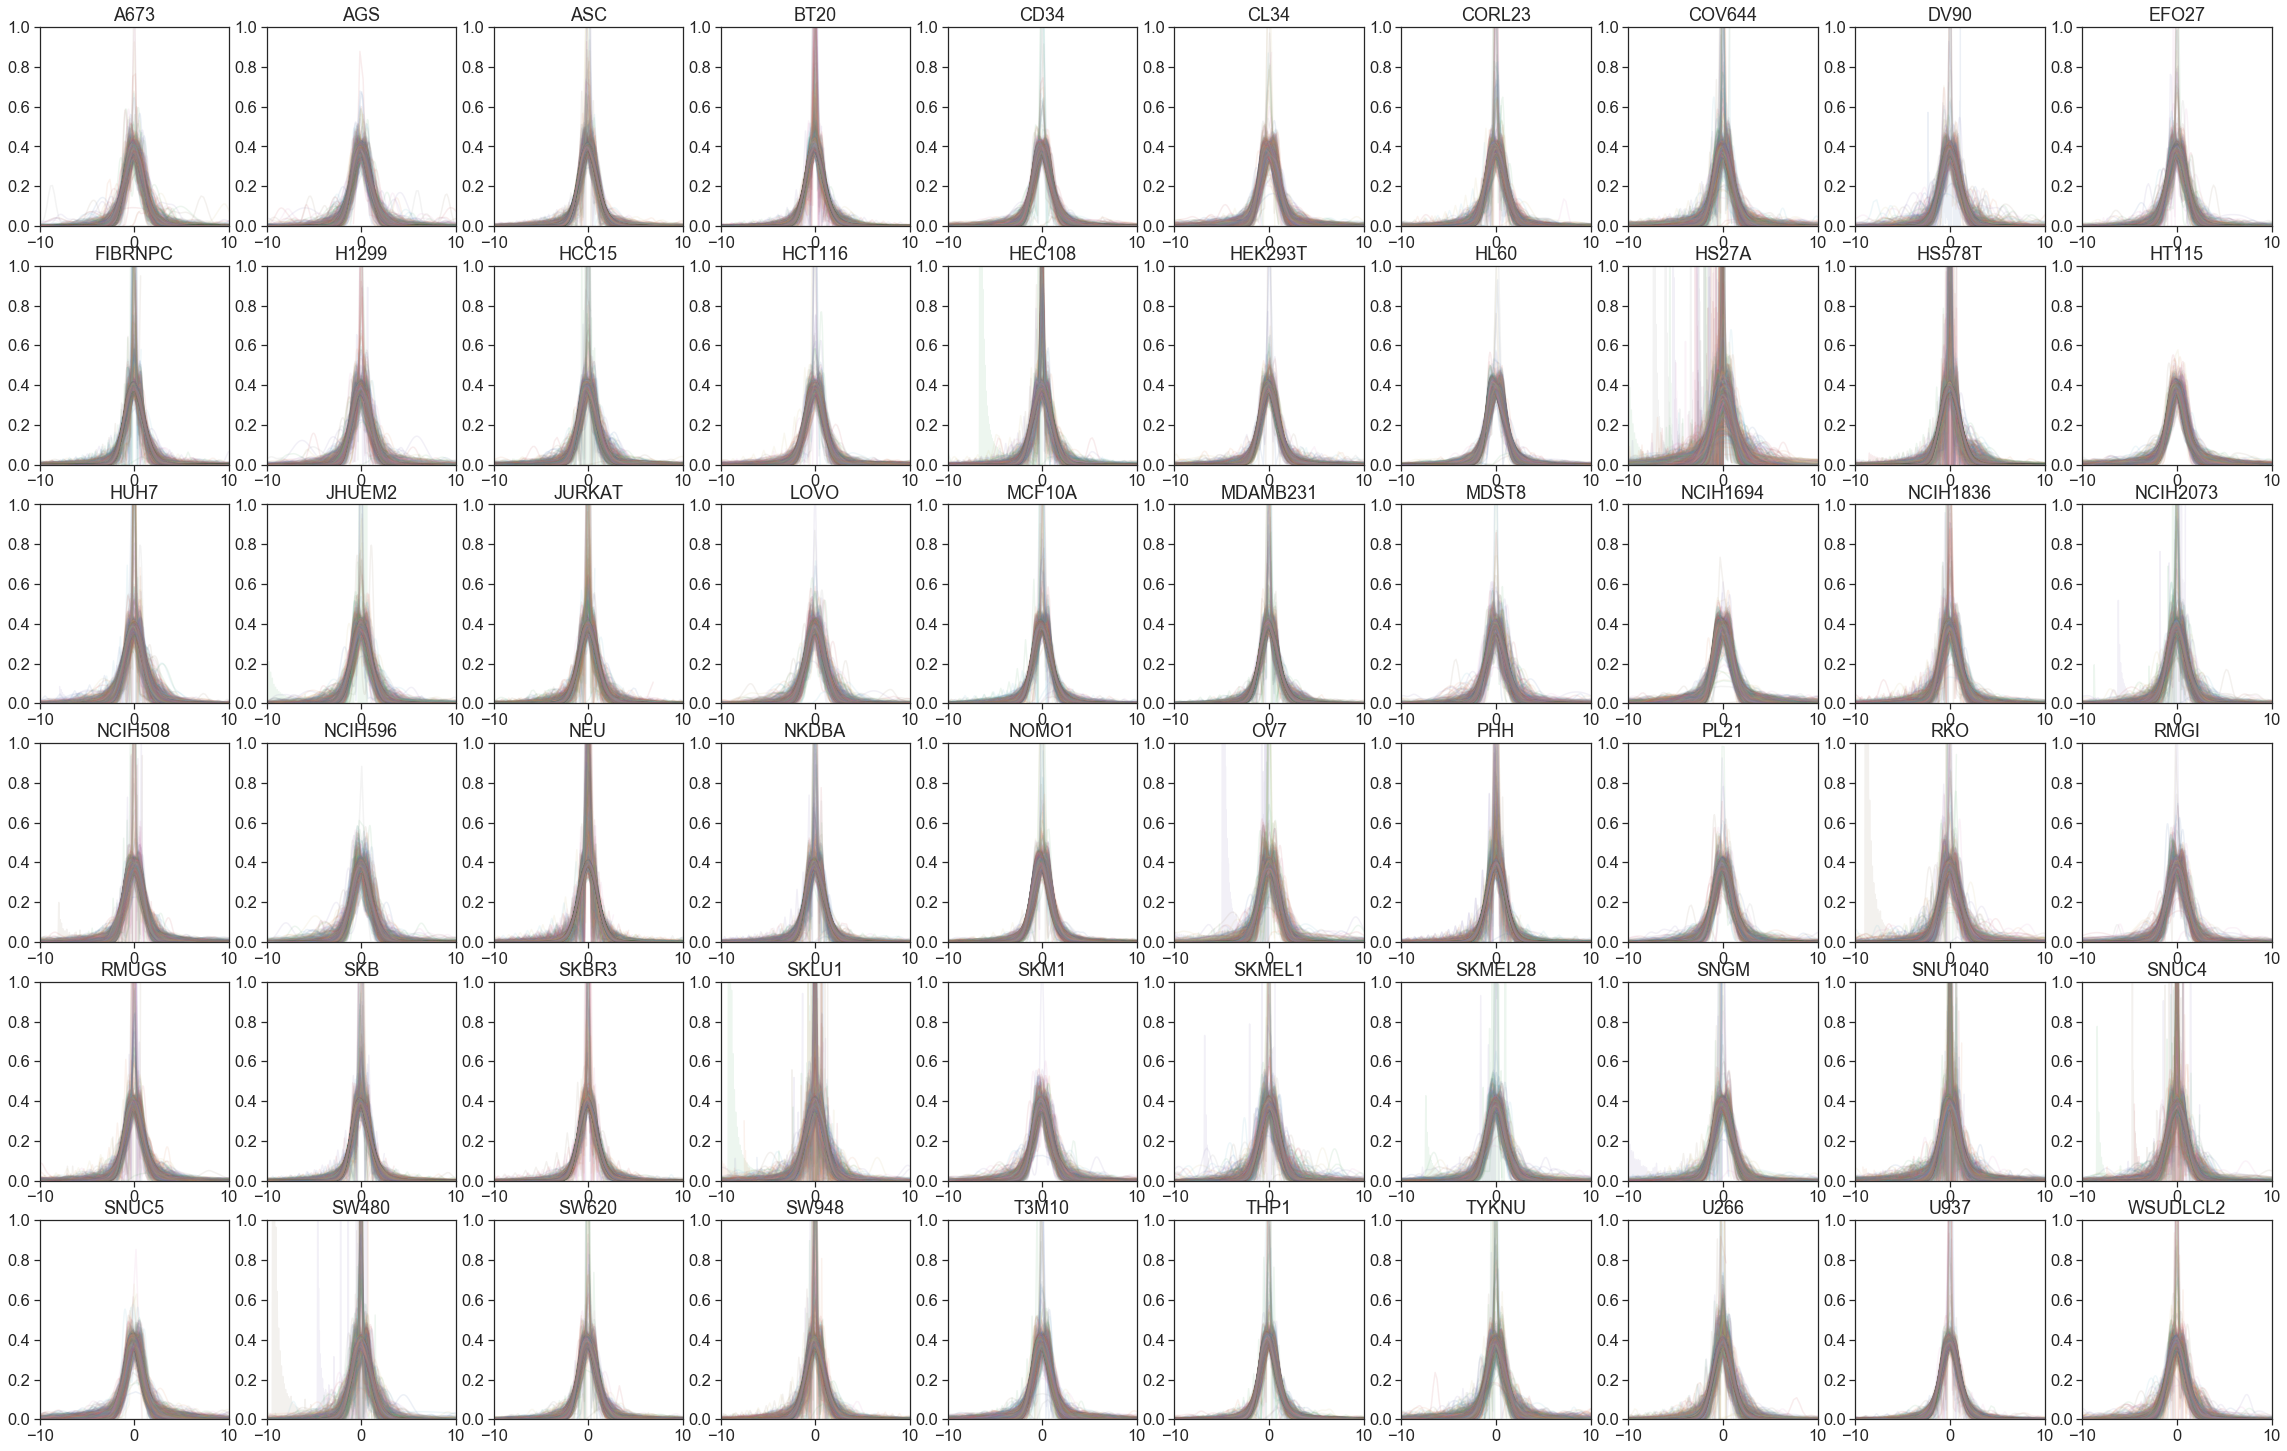

In [6]:
high_peak_genes_dict = {c: [] for c in sorted(list(set(QUIZC_allcells['Cell_type']) 
                            - set(['A375', 'A549', 'HA1E', 'HCC515', 'HEPG2', 'HT29', 'MCF7', 'NPC', 'PC3', 'VCAP'])))}
all_zeros_genes_dict = {c: [] for c in sorted(list(set(QUIZC_allcells['Cell_type']) 
                            - set(['A375', 'A549', 'HA1E', 'HCC515', 'HEPG2', 'HT29', 'MCF7', 'NPC', 'PC3', 'VCAP'])))}
KDE_zero_bw_genes_dict = {c: [] for c in sorted(list(set(QUIZC_allcells['Cell_type']) 
                            - set(['A375', 'A549', 'HA1E', 'HCC515', 'HEPG2', 'HT29', 'MCF7', 'NPC', 'PC3', 'VCAP'])))}

fig = plt.figure()
fig.set_size_inches(40, 30)
sns.set(font_scale=1.5)
with sns.axes_style('ticks'):
    for n, cell_type in enumerate(tqdm(sorted(list(set(QUIZC_allcells['Cell_type']) 
                                                   - set(['A375', 'A549', 'HA1E', 'HCC515', 'HEPG2', 'HT29', 'MCF7', 'NPC', 'PC3', 'VCAP']))), 
                                       position=0, leave=True)):
        
        level4 = pd.read_feather(rev_feather_path + 'Level4_all_parsed_%s.feather' % cell_type)
        level4_inst_info = pd.merge( L1000_inst_info, level4.set_index('rid').T.sort_index(), right_index=True, left_on='inst_id')
        level4_pert_iname = level4_inst_info.set_index('pert_iname')[level4['rid']]
        level4_pert_iname_z = ((level4_pert_iname - level4_pert_iname.mean(axis=0))) / level4_pert_iname.std(axis=0)
        level4_pert_iname_z = level4_pert_iname_z.reset_index()
        level4_pert_iname_z_grouped = level4_pert_iname_z.groupby('pert_iname')        
      
        plt.subplot(7, 10, n+1)
        for nn, i in enumerate(level4_pert_iname.columns):
            try:
                ax = sns.kdeplot(data=level4_pert_iname[i], legend=False,  alpha=0.1)
                if (level4_pert_iname[i]==0.0).all() == False:
                    temp_peak_data = ax.lines[nn].get_xydata()
                    if temp_peak_data[:, 1].max() > 0.5:
                        high_peak_genes_dict[cell_type].append(i)            
                else:
                    all_zeros_genes_dict[cell_type].append(i)

            except RuntimeError as re:
                if str(re).startswith("Selected KDE bandwidth is 0. Cannot estiamte density."):
                    KDE_zero_bw_genes_dict[cell_type].append(i)
                    ax = sns.kdeplot(data=level4_pert_iname[i], legend=False,  alpha=0.1, bw=1.0)
                    if (level4_pert_iname[i]==0.0).all() == False:
                        temp_peak_data = ax.lines[nn].get_xydata()
                        if temp_peak_data[:, 1].max() > 0.5:
                            high_peak_genes_dict[cell_type].append(i)
                    else:
                        all_zeros_genes_dict[cell_type].append(i)   
                else:
                    raise re
        plt.xlim(-10, 10)
        plt.ylim(0, 1.0)
        plt.title(cell_type)
    
    plt.savefig(proj_output_path + 'allcells_kde_plots.pdf', format='pdf') 
    plt.show()

In [7]:
cell_type = 'HS27A'
level4 = pd.read_feather(rev_feather_path + 'Level4_all_parsed_%s.feather' % cell_type)
level4_inst_info = pd.merge( L1000_inst_info, level4.set_index('rid').T.sort_index(), right_index=True, left_on='inst_id')
level4_pert_iname = level4_inst_info.set_index('pert_iname')[level4['rid']]
level4_pert_iname_z = ((level4_pert_iname - level4_pert_iname.mean(axis=0))) / level4_pert_iname.std(axis=0)
level4_pert_iname_z = level4_pert_iname_z.reset_index()
level4_pert_iname_z_grouped = level4_pert_iname_z.groupby('pert_iname')      

In [8]:
level4_pert_iname['10049'].loc['parthenolide']

pert_iname
parthenolide     0.0054
parthenolide     0.0088
parthenolide    -7.1928
parthenolide   -11.3915
parthenolide    -6.2121
parthenolide    -4.6924
Name: 10049, dtype: float32

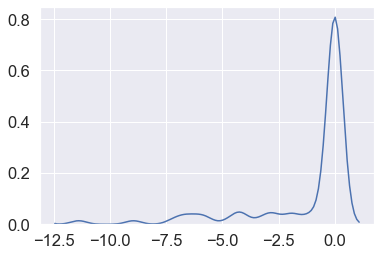

In [9]:
sns.kdeplot(data=level4_pert_iname['10049'], legend=False,  alpha=1)

## Analysis of potentially spurious genes in QUIZ-C networks (Supp. Tables 1 and 2)

In [12]:
MODZ_edgelist_df_dict, MODZ_nodelist_df_dict, MODZ_allcells, \
MODZ_allgenes, MODZ_alldrugs, MODZ_allnodes = import_CD_MODZ_networks(proj_path + 'ALL_MODZ_networks/')

CD_edgelist_df_dict, CD_nodelist_df_dict, CD_allcells, \
CD_allgenes, CD_alldrugs, CD_allnodes = import_CD_MODZ_networks(proj_path + 'ALL_CD_networks/')

In [13]:
QUIZC_diG_dict = generate_diG_dict(QUIZC_nodelist_df_dict, QUIZC_edgelist_df_dict, QUIZC_allcells)
MODZ_diG_dict = generate_diG_dict(MODZ_nodelist_df_dict, MODZ_edgelist_df_dict, MODZ_allcells)
CD_diG_dict = generate_diG_dict(CD_nodelist_df_dict, CD_edgelist_df_dict, CD_allcells)

100%|██████████| 61/61 [00:49<00:00,  1.24it/s]


In [14]:
QUIZC_norm_in_degree_df = pd.DataFrame(index=QUIZC_allgenes['Gene_symbol'], columns=QUIZC_allcells['Cell_type'])
QUIZC_norm_out_degree_df = pd.DataFrame(index=QUIZC_alldrugs['Pert_iname'], columns=QUIZC_allcells['Cell_type'])

for c in tqdm(QUIZC_norm_in_degree_df.columns):
    QUIZC_norm_in_degree_df[c] = pd.Series(pd.DataFrame.from_dict(QUIZC_diG_dict[c].in_degree()).set_index(0)[1] / 
                                     len(QUIZC_nodelist_df_dict[c][QUIZC_nodelist_df_dict[c]['Type']=='Drug']['Id'].unique()), 
                                           index=QUIZC_allgenes['Gene_symbol'])
    QUIZC_norm_out_degree_df[c] = pd.Series(pd.DataFrame.from_dict(QUIZC_diG_dict[c].out_degree()).set_index(0)[1] / 
                                      len(QUIZC_nodelist_df_dict[c][QUIZC_nodelist_df_dict[c]['Type']=='Gene']['Id'].unique()), 
                                            index=QUIZC_alldrugs['Pert_iname'])
    
QUIZC_norm_in_degree_cellno_df = pd.DataFrame(index=QUIZC_allgenes['Gene_symbol'])
QUIZC_norm_in_degree_cellno_df['# cell lines gene is in'] = pd.Series(QUIZC_norm_in_degree_df.count(axis=1), 
                                                                      index=QUIZC_allgenes['Gene_symbol'])
QUIZC_norm_in_degree_cellno_df['mean norm. in-degree'] = pd.Series(QUIZC_norm_in_degree_df.mean(axis=1), 
                                                                   index=QUIZC_allgenes['Gene_symbol'])
QUIZC_norm_in_degree_cellno_df['norm. in-degree std.dev.'] = pd.Series(QUIZC_norm_in_degree_df.std(axis=1, ddof=0), 
                                                                       index=QUIZC_allgenes['Gene_symbol'])

QUIZC_norm_out_degree_cellno_df = pd.DataFrame(index=QUIZC_alldrugs['Pert_iname'])
QUIZC_norm_out_degree_cellno_df['# cell lines drug is in'] = pd.Series(QUIZC_norm_out_degree_df.count(axis=1), 
                                                                       index=QUIZC_alldrugs['Pert_iname'])
QUIZC_norm_out_degree_cellno_df['mean norm. out-degree'] = pd.Series(QUIZC_norm_out_degree_df.mean(axis=1), 
                                                                     index=QUIZC_alldrugs['Pert_iname'])
QUIZC_norm_out_degree_cellno_df['norm. out-degree std.dev.'] = pd.Series(QUIZC_norm_out_degree_df.std(axis=1, ddof=0), 
                                                                         index=QUIZC_alldrugs['Pert_iname'])

MODZ_norm_in_degree_df = pd.DataFrame(index=MODZ_allgenes['Gene_symbol'], columns=MODZ_allcells['Cell_type'])
MODZ_norm_out_degree_df = pd.DataFrame(index=MODZ_alldrugs['Pert_iname'], columns=MODZ_allcells['Cell_type'])

for c in tqdm(MODZ_norm_in_degree_df.columns):
    MODZ_norm_in_degree_df[c] = pd.Series(pd.DataFrame.from_dict(MODZ_diG_dict[c].in_degree()).set_index(0)[1] / 
                                     len(MODZ_nodelist_df_dict[c][MODZ_nodelist_df_dict[c]['Type']=='Drug']['Id'].unique()), 
                                           index=MODZ_allgenes['Gene_symbol'])
    MODZ_norm_out_degree_df[c] = pd.Series(pd.DataFrame.from_dict(MODZ_diG_dict[c].out_degree()).set_index(0)[1] / 
                                      len(MODZ_nodelist_df_dict[c][MODZ_nodelist_df_dict[c]['Type']=='Gene']['Id'].unique()), 
                                            index=MODZ_alldrugs['Pert_iname'])
    
MODZ_norm_in_degree_cellno_df = pd.DataFrame(index=MODZ_allgenes['Gene_symbol'])
MODZ_norm_in_degree_cellno_df['# cell lines gene is in'] = pd.Series(MODZ_norm_in_degree_df.count(axis=1), 
                                                                      index=MODZ_allgenes['Gene_symbol'])
MODZ_norm_in_degree_cellno_df['mean norm. in-degree'] = pd.Series(MODZ_norm_in_degree_df.mean(axis=1), 
                                                                   index=MODZ_allgenes['Gene_symbol'])
MODZ_norm_in_degree_cellno_df['norm. in-degree std.dev.'] = pd.Series(MODZ_norm_in_degree_df.std(axis=1, ddof=0), 
                                                                       index=MODZ_allgenes['Gene_symbol'])

MODZ_norm_out_degree_cellno_df = pd.DataFrame(index=MODZ_alldrugs['Pert_iname'])
MODZ_norm_out_degree_cellno_df['# cell lines drug is in'] = pd.Series(MODZ_norm_out_degree_df.count(axis=1), 
                                                                       index=MODZ_alldrugs['Pert_iname'])
MODZ_norm_out_degree_cellno_df['mean norm. out-degree'] = pd.Series(MODZ_norm_out_degree_df.mean(axis=1), 
                                                                     index=MODZ_alldrugs['Pert_iname'])
MODZ_norm_out_degree_cellno_df['norm. out-degree std.dev.'] = pd.Series(MODZ_norm_out_degree_df.std(axis=1, ddof=0), 
                                                                         index=MODZ_alldrugs['Pert_iname'])

CD_norm_in_degree_df = pd.DataFrame(index=CD_allgenes['Gene_symbol'], columns=CD_allcells['Cell_type'])
CD_norm_out_degree_df = pd.DataFrame(index=CD_alldrugs['Pert_iname'], columns=CD_allcells['Cell_type'])

for c in tqdm(CD_norm_in_degree_df.columns):
    CD_norm_in_degree_df[c] = pd.Series(pd.DataFrame.from_dict(CD_diG_dict[c].in_degree()).set_index(0)[1] / 
                                     len(CD_nodelist_df_dict[c][CD_nodelist_df_dict[c]['Type']=='Drug']['Id'].unique()), 
                                           index=CD_allgenes['Gene_symbol'])
    CD_norm_out_degree_df[c] = pd.Series(pd.DataFrame.from_dict(CD_diG_dict[c].out_degree()).set_index(0)[1] / 
                                      len(CD_nodelist_df_dict[c][CD_nodelist_df_dict[c]['Type']=='Gene']['Id'].unique()), 
                                            index=CD_alldrugs['Pert_iname'])
    
CD_norm_in_degree_cellno_df = pd.DataFrame(index=CD_allgenes['Gene_symbol'])
CD_norm_in_degree_cellno_df['# cell lines gene is in'] = pd.Series(CD_norm_in_degree_df.count(axis=1), 
                                                                      index=CD_allgenes['Gene_symbol'])
CD_norm_in_degree_cellno_df['mean norm. in-degree'] = pd.Series(CD_norm_in_degree_df.mean(axis=1), 
                                                                   index=CD_allgenes['Gene_symbol'])
CD_norm_in_degree_cellno_df['norm. in-degree std.dev.'] = pd.Series(CD_norm_in_degree_df.std(axis=1, ddof=0), 
                                                                       index=CD_allgenes['Gene_symbol'])

CD_norm_out_degree_cellno_df = pd.DataFrame(index=CD_alldrugs['Pert_iname'])
CD_norm_out_degree_cellno_df['# cell lines drug is in'] = pd.Series(CD_norm_out_degree_df.count(axis=1), 
                                                                       index=CD_alldrugs['Pert_iname'])
CD_norm_out_degree_cellno_df['mean norm. out-degree'] = pd.Series(CD_norm_out_degree_df.mean(axis=1), 
                                                                     index=CD_alldrugs['Pert_iname'])
CD_norm_out_degree_cellno_df['norm. out-degree std.dev.'] = pd.Series(CD_norm_out_degree_df.std(axis=1, ddof=0), 
                                                                         index=CD_alldrugs['Pert_iname'])

100%|██████████| 61/61 [00:00<00:00, 69.78it/s]


In [15]:
QUIZC_percent_spurious_df = pd.DataFrame(index = high_peak_genes_dict.keys(), columns=['high_peak_genes (%)', 'all_zeros_genes (%)', 
                                                                                       'KDE_zero_bw_genes (%)'])
for i in high_peak_genes_dict.keys():
    QUIZC_percent_spurious_df.at[i, 'high_peak_genes (%)'] = (len(set(QUIZC_edgelist_df_dict[i]['Target'].unique()) & 
                                                          set(L1000_gene_info[L1000_gene_info['pr_gene_id']
                                                                              .isin(set(high_peak_genes_dict[i]))]['pr_gene_symbol'])) /
                                                          len(set(QUIZC_edgelist_df_dict[i]['Target'].unique())))  * 100
    QUIZC_percent_spurious_df.at[i, 'all_zeros_genes (%)'] = (len(set(QUIZC_edgelist_df_dict[i]['Target'].unique()) & 
                                                          set(L1000_gene_info[L1000_gene_info['pr_gene_id']
                                                                              .isin(set(all_zeros_genes_dict[i]))]['pr_gene_symbol'])) /
                                                           len(set(QUIZC_edgelist_df_dict[i]['Target'].unique())))  * 100
    QUIZC_percent_spurious_df.at[i, 'KDE_zero_bw_genes (%)'] = (len(set(QUIZC_edgelist_df_dict[i]['Target'].unique()) & 
                                                          set(L1000_gene_info[L1000_gene_info['pr_gene_id']
                                                                              .isin(set(KDE_zero_bw_genes_dict[i]))]['pr_gene_symbol'])) /
                                                             len(set(QUIZC_edgelist_df_dict[i]['Target'].unique())))  * 100
    
QUIZC_percent_spurious_df.to_csv(proj_output_path + 'QUIZC_percent_spurious_df.csv')

In [17]:
spurious_indegree_df = pd.DataFrame(index=high_peak_genes_dict.keys(), columns=['high_peak_genes_mean', 'allexcept_high_peak_genes_mean', 
                                                                                'high_peak_genes_MWU_pval',
                                                                               'all_zeros_genes_mean', 'allexcept_all_zeros_genes_mean', 
                                                                                'all_zeros_genes_MWU_pval',
                                                                               'KDE_zero_bw_genes_mean', 'allexcept_KDE_zero_bw_genes_mean', 
                                                                                'KDE_zero_bw_genes_MWU_pval'])
for c in high_peak_genes_dict.keys():
    spurious_indegree_df.at[c, 'high_peak_genes_mean'] = QUIZC_norm_in_degree_df[c][QUIZC_norm_in_degree_df[c].index
                                                                        .isin(set(L1000_gene_info[L1000_gene_info['pr_gene_id']
                                                                        .isin(set(high_peak_genes_dict[c]))]['pr_gene_symbol']))].dropna().values.mean()
    spurious_indegree_df.at[c, 'allexcept_high_peak_genes_mean'] = QUIZC_norm_in_degree_df[c][QUIZC_norm_in_degree_df[c].index
                                                   .isin(set(QUIZC_norm_in_degree_df[c].index) - set(L1000_gene_info[L1000_gene_info['pr_gene_id']
                                                    .isin(set(high_peak_genes_dict[c]))]['pr_gene_symbol']))].dropna().values.mean()
    spurious_indegree_df.at[c, 'high_peak_genes_MWU_pval'] = st.mannwhitneyu(QUIZC_norm_in_degree_df[c][QUIZC_norm_in_degree_df[c].index
                               .isin(set(QUIZC_norm_in_degree_df[c].index) - set(L1000_gene_info[L1000_gene_info['pr_gene_id']
                                                         .isin(set(high_peak_genes_dict[c]))]['pr_gene_symbol']))].values,
               QUIZC_norm_in_degree_df[c][QUIZC_norm_in_degree_df[c].index
                               .isin(set(L1000_gene_info[L1000_gene_info['pr_gene_id']
                                                         .isin(set(high_peak_genes_dict[c]))]['pr_gene_symbol']))].values)[1]
    
    spurious_indegree_df.at[c, 'all_zeros_genes_mean'] = QUIZC_norm_in_degree_df[c][QUIZC_norm_in_degree_df[c].index
                                                                        .isin(set(L1000_gene_info[L1000_gene_info['pr_gene_id']
                                                                        .isin(set(all_zeros_genes_dict[c]))]['pr_gene_symbol']))].dropna().values.mean()
    spurious_indegree_df.at[c, 'allexcept_all_zeros_genes_mean'] = QUIZC_norm_in_degree_df[c][QUIZC_norm_in_degree_df[c].index
                                                   .isin(set(QUIZC_norm_in_degree_df[c].index) - set(L1000_gene_info[L1000_gene_info['pr_gene_id']
                                                    .isin(set(all_zeros_genes_dict[c]))]['pr_gene_symbol']))].dropna().values.mean()
    spurious_indegree_df.at[c, 'all_zeros_genes_MWU_pval'] = st.mannwhitneyu(QUIZC_norm_in_degree_df[c][QUIZC_norm_in_degree_df[c].index
                               .isin(set(QUIZC_norm_in_degree_df[c].index) - set(L1000_gene_info[L1000_gene_info['pr_gene_id']
                                                         .isin(set(all_zeros_genes_dict[c]))]['pr_gene_symbol']))].values,
               QUIZC_norm_in_degree_df[c][QUIZC_norm_in_degree_df[c].index
                               .isin(set(L1000_gene_info[L1000_gene_info['pr_gene_id']
                                                         .isin(set(all_zeros_genes_dict[c]))]['pr_gene_symbol']))].values)[1]
    
    spurious_indegree_df.at[c, 'KDE_zero_bw_genes_mean'] = QUIZC_norm_in_degree_df[c][QUIZC_norm_in_degree_df[c].index
                                                                        .isin(set(L1000_gene_info[L1000_gene_info['pr_gene_id']
                                                                        .isin(set(KDE_zero_bw_genes_dict[c]))]['pr_gene_symbol']))].dropna().values.mean()
    spurious_indegree_df.at[c, 'allexcept_KDE_zero_bw_genes_mean'] = QUIZC_norm_in_degree_df[c][QUIZC_norm_in_degree_df[c].index
                                                   .isin(set(QUIZC_norm_in_degree_df[c].index) - set(L1000_gene_info[L1000_gene_info['pr_gene_id']
                                                    .isin(set(KDE_zero_bw_genes_dict[c]))]['pr_gene_symbol']))].dropna().values.mean()
    spurious_indegree_df.at[c, 'KDE_zero_bw_genes_MWU_pval'] = st.mannwhitneyu(QUIZC_norm_in_degree_df[c][QUIZC_norm_in_degree_df[c].index
                               .isin(set(QUIZC_norm_in_degree_df[c].index) - set(L1000_gene_info[L1000_gene_info['pr_gene_id']
                                                         .isin(set(KDE_zero_bw_genes_dict[c]))]['pr_gene_symbol']))].values,
               QUIZC_norm_in_degree_df[c][QUIZC_norm_in_degree_df[c].index
                               .isin(set(L1000_gene_info[L1000_gene_info['pr_gene_id']
                                                         .isin(set(KDE_zero_bw_genes_dict[c]))]['pr_gene_symbol']))].values)[1]
    
spurious_indegree_df.to_csv(proj_output_path + 'QUIZC_spurious_indegree_df.csv')

<ipython-input-17-7e57efad75ab>:21: RuntimeWarning: Mean of empty slice.
  spurious_indegree_df.at[c, 'all_zeros_genes_mean'] = QUIZC_norm_in_degree_df[c][QUIZC_norm_in_degree_df[c].index
<ipython-input-17-7e57efad75ab>:34: RuntimeWarning: Mean of empty slice.
  spurious_indegree_df.at[c, 'KDE_zero_bw_genes_mean'] = QUIZC_norm_in_degree_df[c][QUIZC_norm_in_degree_df[c].index


## Distribution of instances in L1000 data (Supp. Fig. 2A)

In [6]:
num_instances_dict = {}

for cell_type in tqdm(QUIZC_allcells['Cell_type'], position=0, leave=True):

    level4 = pd.read_feather(rev_feather_path + 'Level4_all_parsed_%s.feather' % cell_type)
    level4_inst_info = pd.merge( L1000_inst_info, level4.set_index('rid').T.sort_index(), right_index=True, left_on='inst_id')
    level4_pert_iname = level4_inst_info.set_index('pert_iname')[level4['rid']]
    num_instances_dict[cell_type] = level4_pert_iname.groupby('pert_iname').size().values
    # level4_pert_iname_z = ((level4_pert_iname - level4_pert_iname.mean(axis=0))) / level4_pert_iname.std(axis=0)
    # level4_pert_iname_z = level4_pert_iname_z.reset_index()
    # level4_pert_iname_z_grouped = level4_pert_iname_z.groupby('pert_iname')

100%|██████████| 70/70 [20:19<00:00, 17.42s/it] 


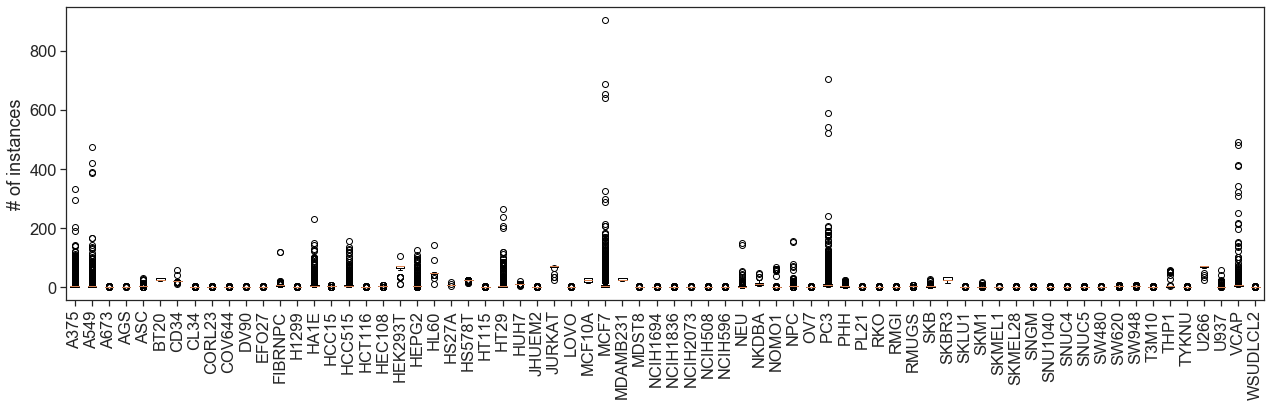

In [7]:
inst_labels, inst_data = [*zip(*num_instances_dict.items())]

fig = plt.figure()
fig.set_size_inches(18, 6)
sns.set(font_scale=1.5)
with sns.axes_style('ticks'):
    plt.boxplot(inst_data)
    plt.xticks(range(1, len(inst_labels) + 1), inst_labels)
    plt.xticks(rotation=90)
    plt.ylabel('# of instances')
    plt.xlabel('')
    plt.tight_layout()
    plt.savefig(proj_output_path + 'num_instances.pdf', format='pdf')
plt.show()

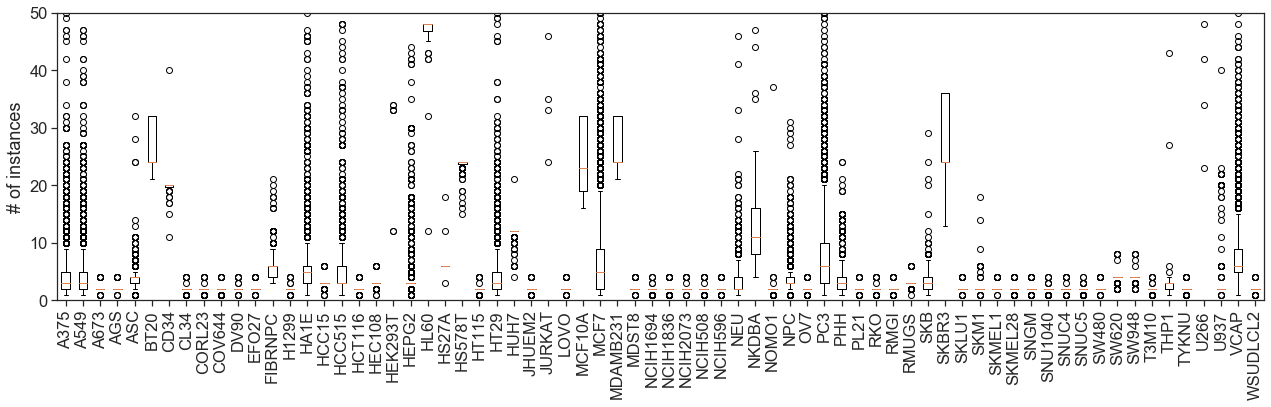

In [11]:
inst_labels, inst_data = [*zip(*num_instances_dict.items())]

fig = plt.figure()
fig.set_size_inches(18, 6)
sns.set(font_scale=1.5)
with sns.axes_style('ticks'):
    plt.boxplot(inst_data)
    plt.xticks(range(1, len(inst_labels) + 1), inst_labels)
    plt.xticks(rotation=90)
    plt.ylabel('# of instances')
    plt.xlabel('')
    plt.ylim(0, 50)
    plt.tight_layout()
    plt.savefig(proj_output_path + 'num_instances_zoom.pdf', format='pdf')
plt.show()

## Dose and time distributions in L1000 Level 4 data for each cell line 

100%|██████████| 60/60 [09:35<00:00,  9.59s/it]


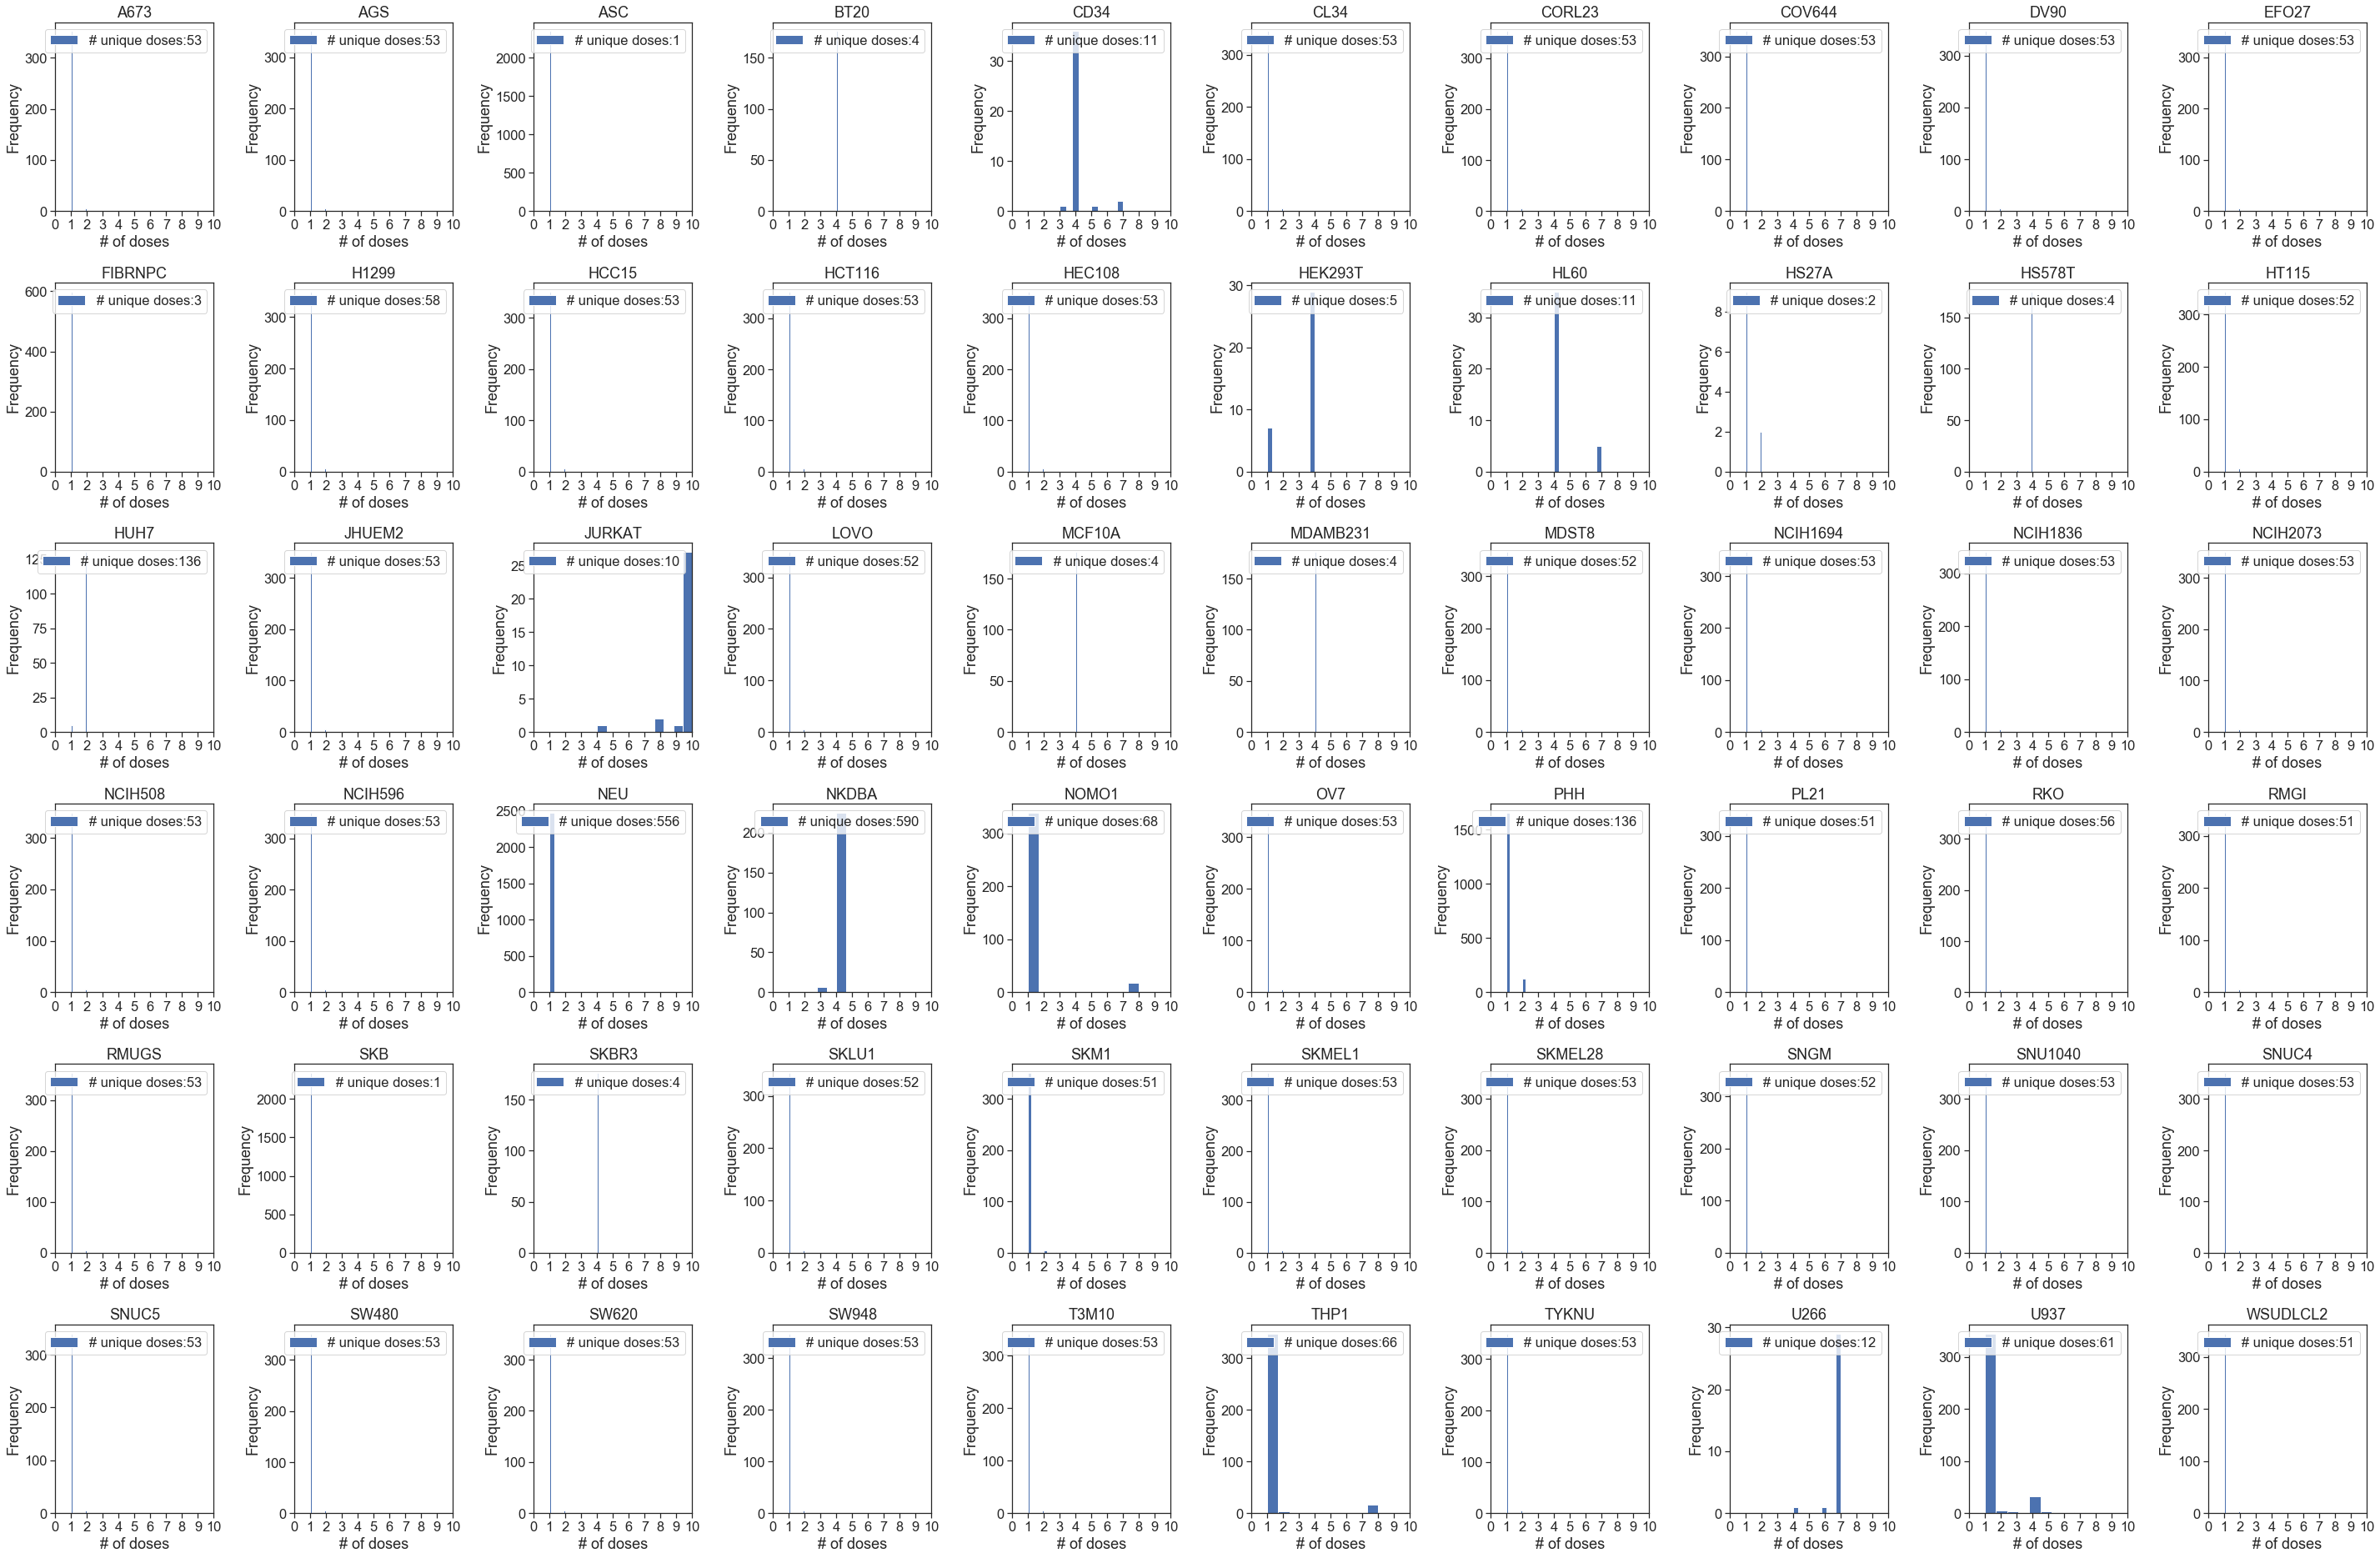

In [8]:
fig = plt.figure()
fig.set_size_inches(40, 30)
sns.set(font_scale=1.5)
with sns.axes_style('ticks'):
    for n, cell_type in enumerate(tqdm(sorted(list(set(QUIZC_allcells['Cell_type']) 
                                                   - set(['A375', 'A549', 'HA1E', 'HCC515', 'HEPG2', 'HT29', 'MCF7', 'NPC', 'PC3', 'VCAP']))), 
                                       position=0, leave=True)):
        
        level4 = pd.read_feather(rev_feather_path + 'Level4_all_parsed_%s.feather' % cell_type)
        level4_inst_info = pd.merge( L1000_inst_info, level4.set_index('rid').T.sort_index(), right_index=True, left_on='inst_id')
        level4_pert_iname = level4_inst_info.set_index('pert_iname')[level4['rid']]
        level4_pert_iname_z = ((level4_pert_iname - level4_pert_iname.mean(axis=0))) / level4_pert_iname.std(axis=0)
        level4_pert_iname_z = level4_pert_iname_z.reset_index()
        level4_pert_iname_z_grouped = level4_pert_iname_z.groupby('pert_iname')         
        
        temp_dose_time_counts_df = level4_inst_info[['pert_iname', 'pert_dose', 'pert_time']].groupby('pert_iname').nunique()\
                                                                                                        .sort_values('pert_time', ascending=False)
        
        plt.subplot(7, 10, n+1)  
        plt.hist(temp_dose_time_counts_df['pert_dose'], bins=10, label='# unique doses:%s' % len(level4_inst_info['pert_dose'].unique()))
        plt.xlim(0, 10)
        plt.xticks(np.arange(11))
        plt.xlabel('# of doses')
        plt.ylabel('Frequency')
        plt.title(cell_type)
        plt.legend()
        plt.tight_layout()
        plt.savefig(proj_output_path + 'L1000_dose_counts.pdf', format='pdf')
    plt.show()

100%|██████████| 60/60 [10:19<00:00, 10.33s/it]


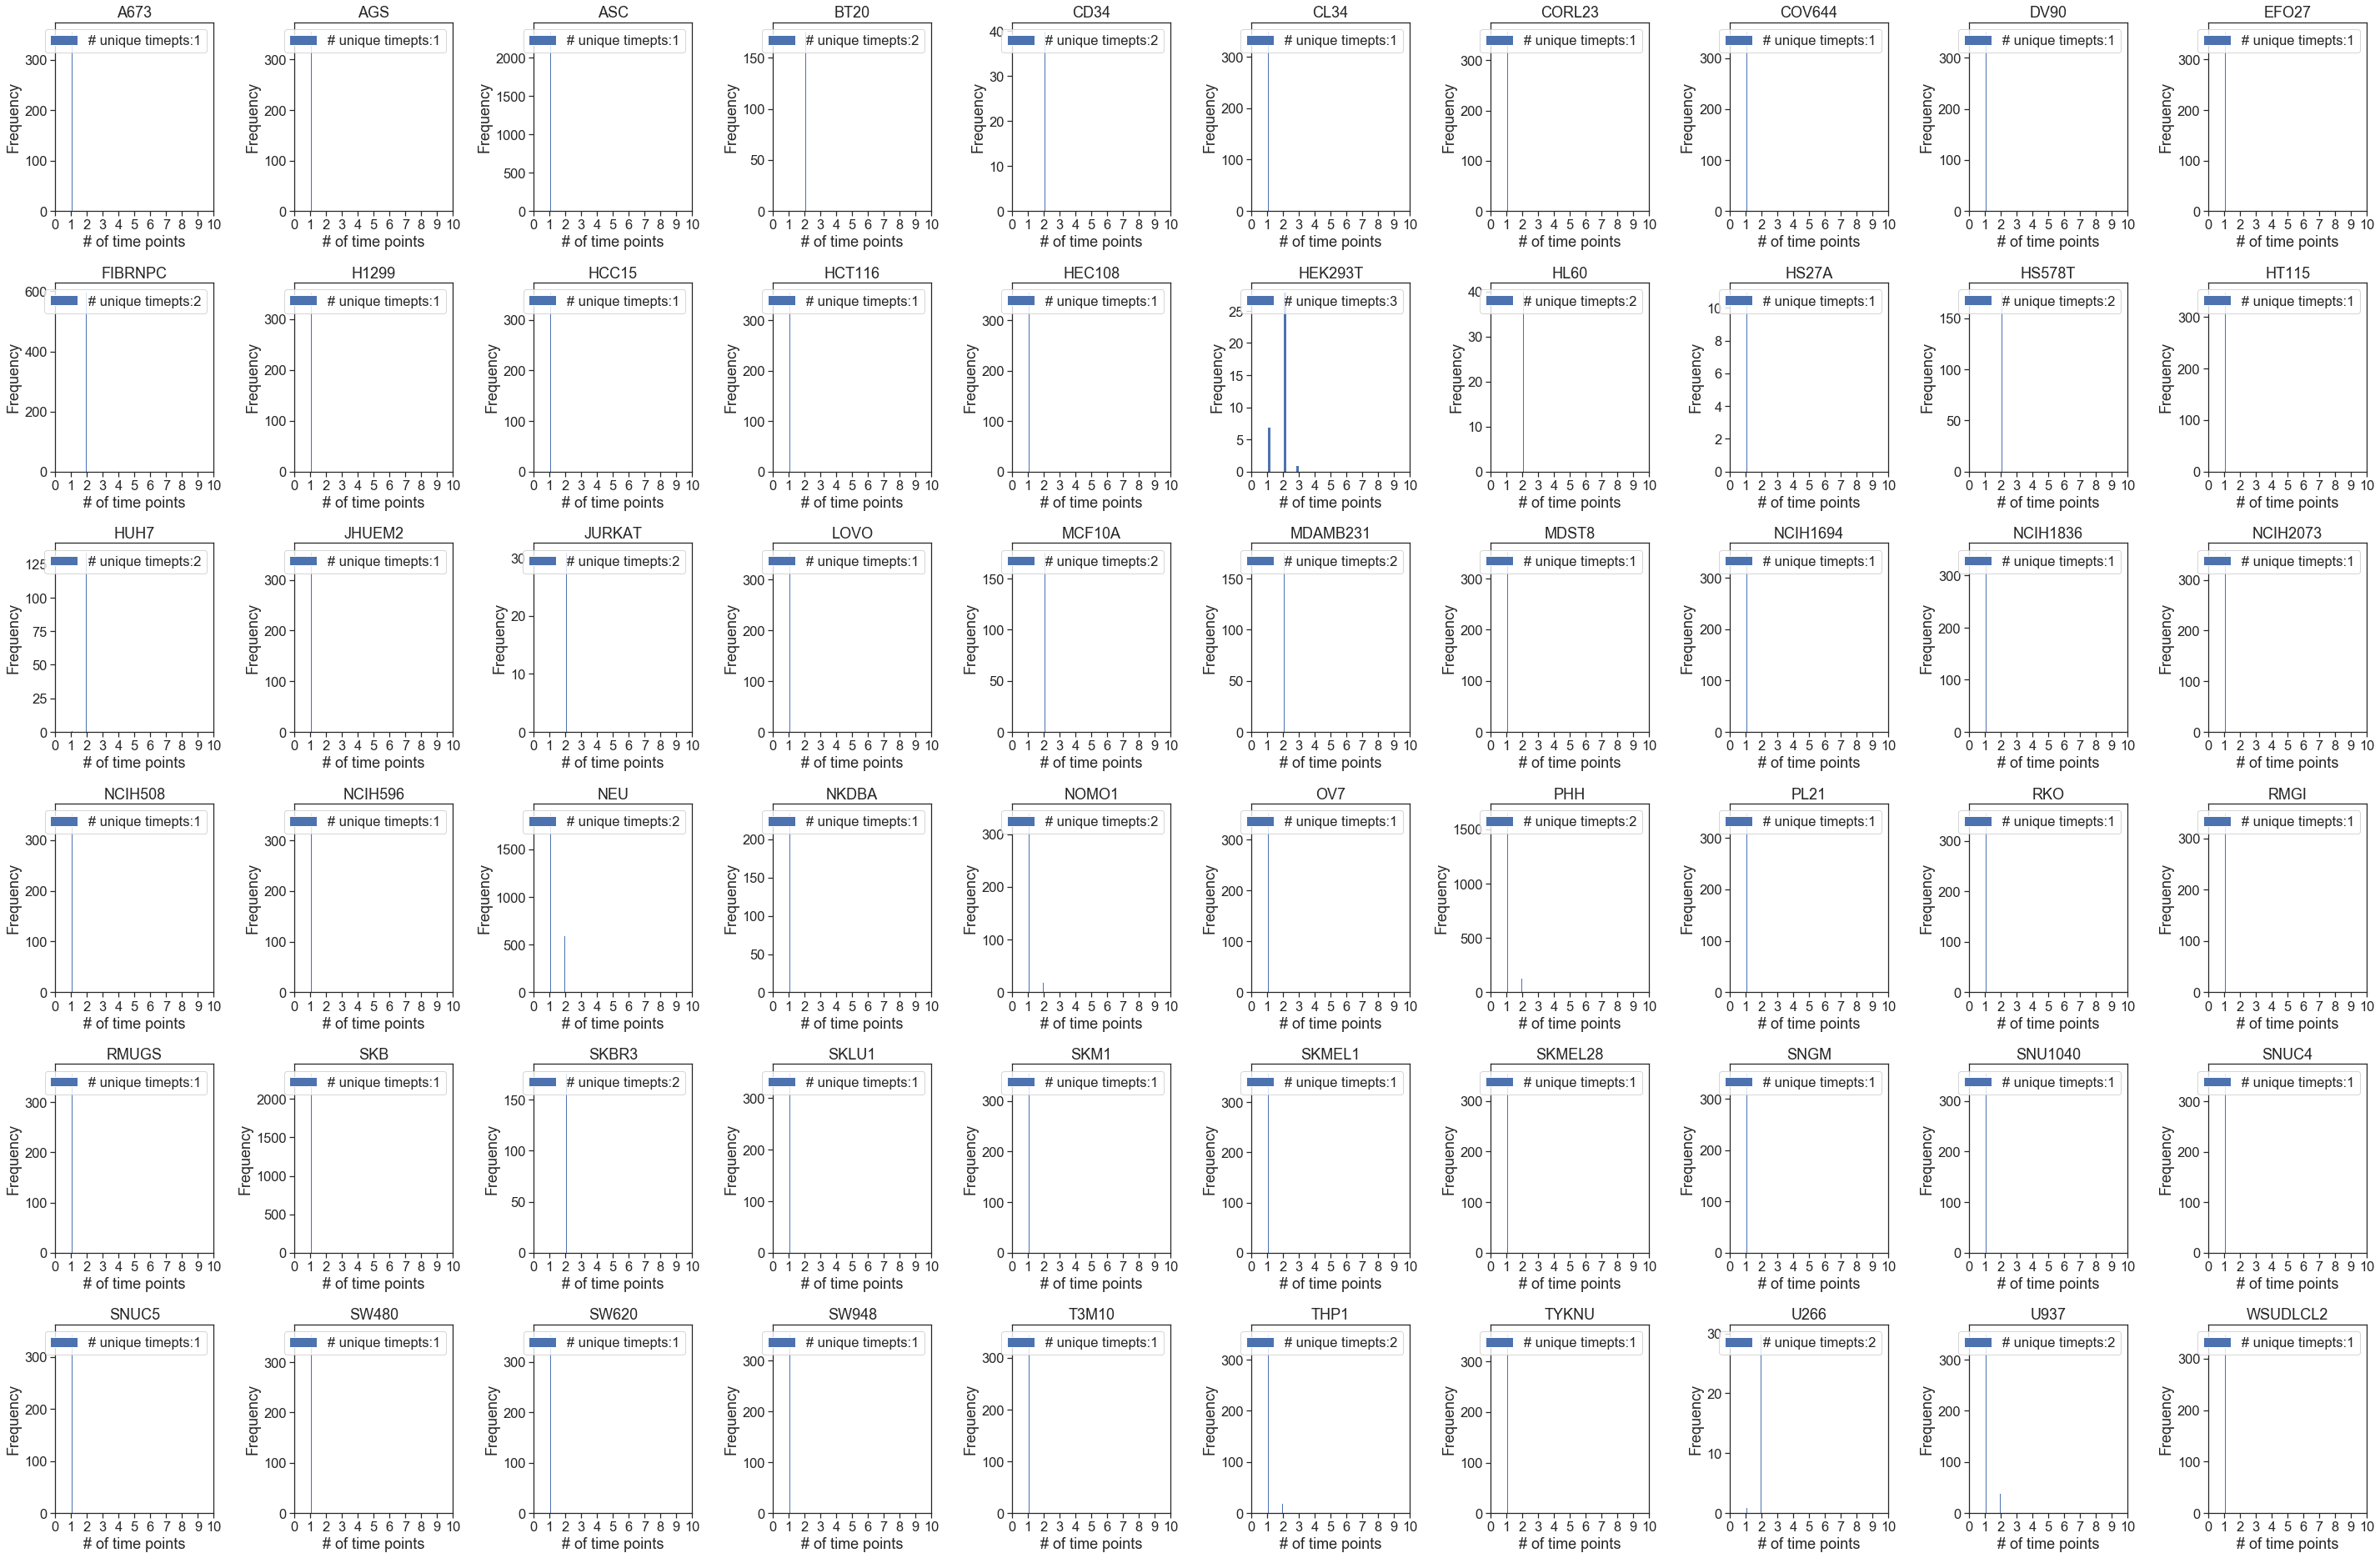

In [10]:
fig = plt.figure()
fig.set_size_inches(40, 30)
sns.set(font_scale=1.5)
with sns.axes_style('ticks'):
    for n, cell_type in enumerate(tqdm(sorted(list(set(QUIZC_allcells['Cell_type']) 
                                                   - set(['A375', 'A549', 'HA1E', 'HCC515', 'HEPG2', 'HT29', 'MCF7', 'NPC', 'PC3', 'VCAP']))), 
                                       position=0, leave=True)):
        
        level4 = pd.read_feather(rev_feather_path + 'Level4_all_parsed_%s.feather' % cell_type)
        level4_inst_info = pd.merge( L1000_inst_info, level4.set_index('rid').T.sort_index(), right_index=True, left_on='inst_id')
        level4_pert_iname = level4_inst_info.set_index('pert_iname')[level4['rid']]
        level4_pert_iname_z = ((level4_pert_iname - level4_pert_iname.mean(axis=0))) / level4_pert_iname.std(axis=0)
        level4_pert_iname_z = level4_pert_iname_z.reset_index()
        level4_pert_iname_z_grouped = level4_pert_iname_z.groupby('pert_iname')         
        
        temp_dose_time_counts_df = level4_inst_info[['pert_iname', 'pert_dose', 'pert_time']].groupby('pert_iname').nunique()\
                                                                                                        .sort_values('pert_time', ascending=False)
        
        plt.subplot(7, 10, n+1)  
        plt.hist(temp_dose_time_counts_df['pert_time'], bins=10, label='# unique timepts:%s' % len(level4_inst_info['pert_time'].unique()))
        plt.xlim(0, 10)
        plt.xticks(np.arange(11))
        plt.xlabel('# of time points')
        plt.ylabel('Frequency')
        plt.title(cell_type)
        plt.legend()
        plt.tight_layout()
        plt.savefig(proj_output_path + 'L1000_time_counts.pdf', format='pdf')
    plt.show()

100%|██████████| 60/60 [09:40<00:00,  9.67s/it]


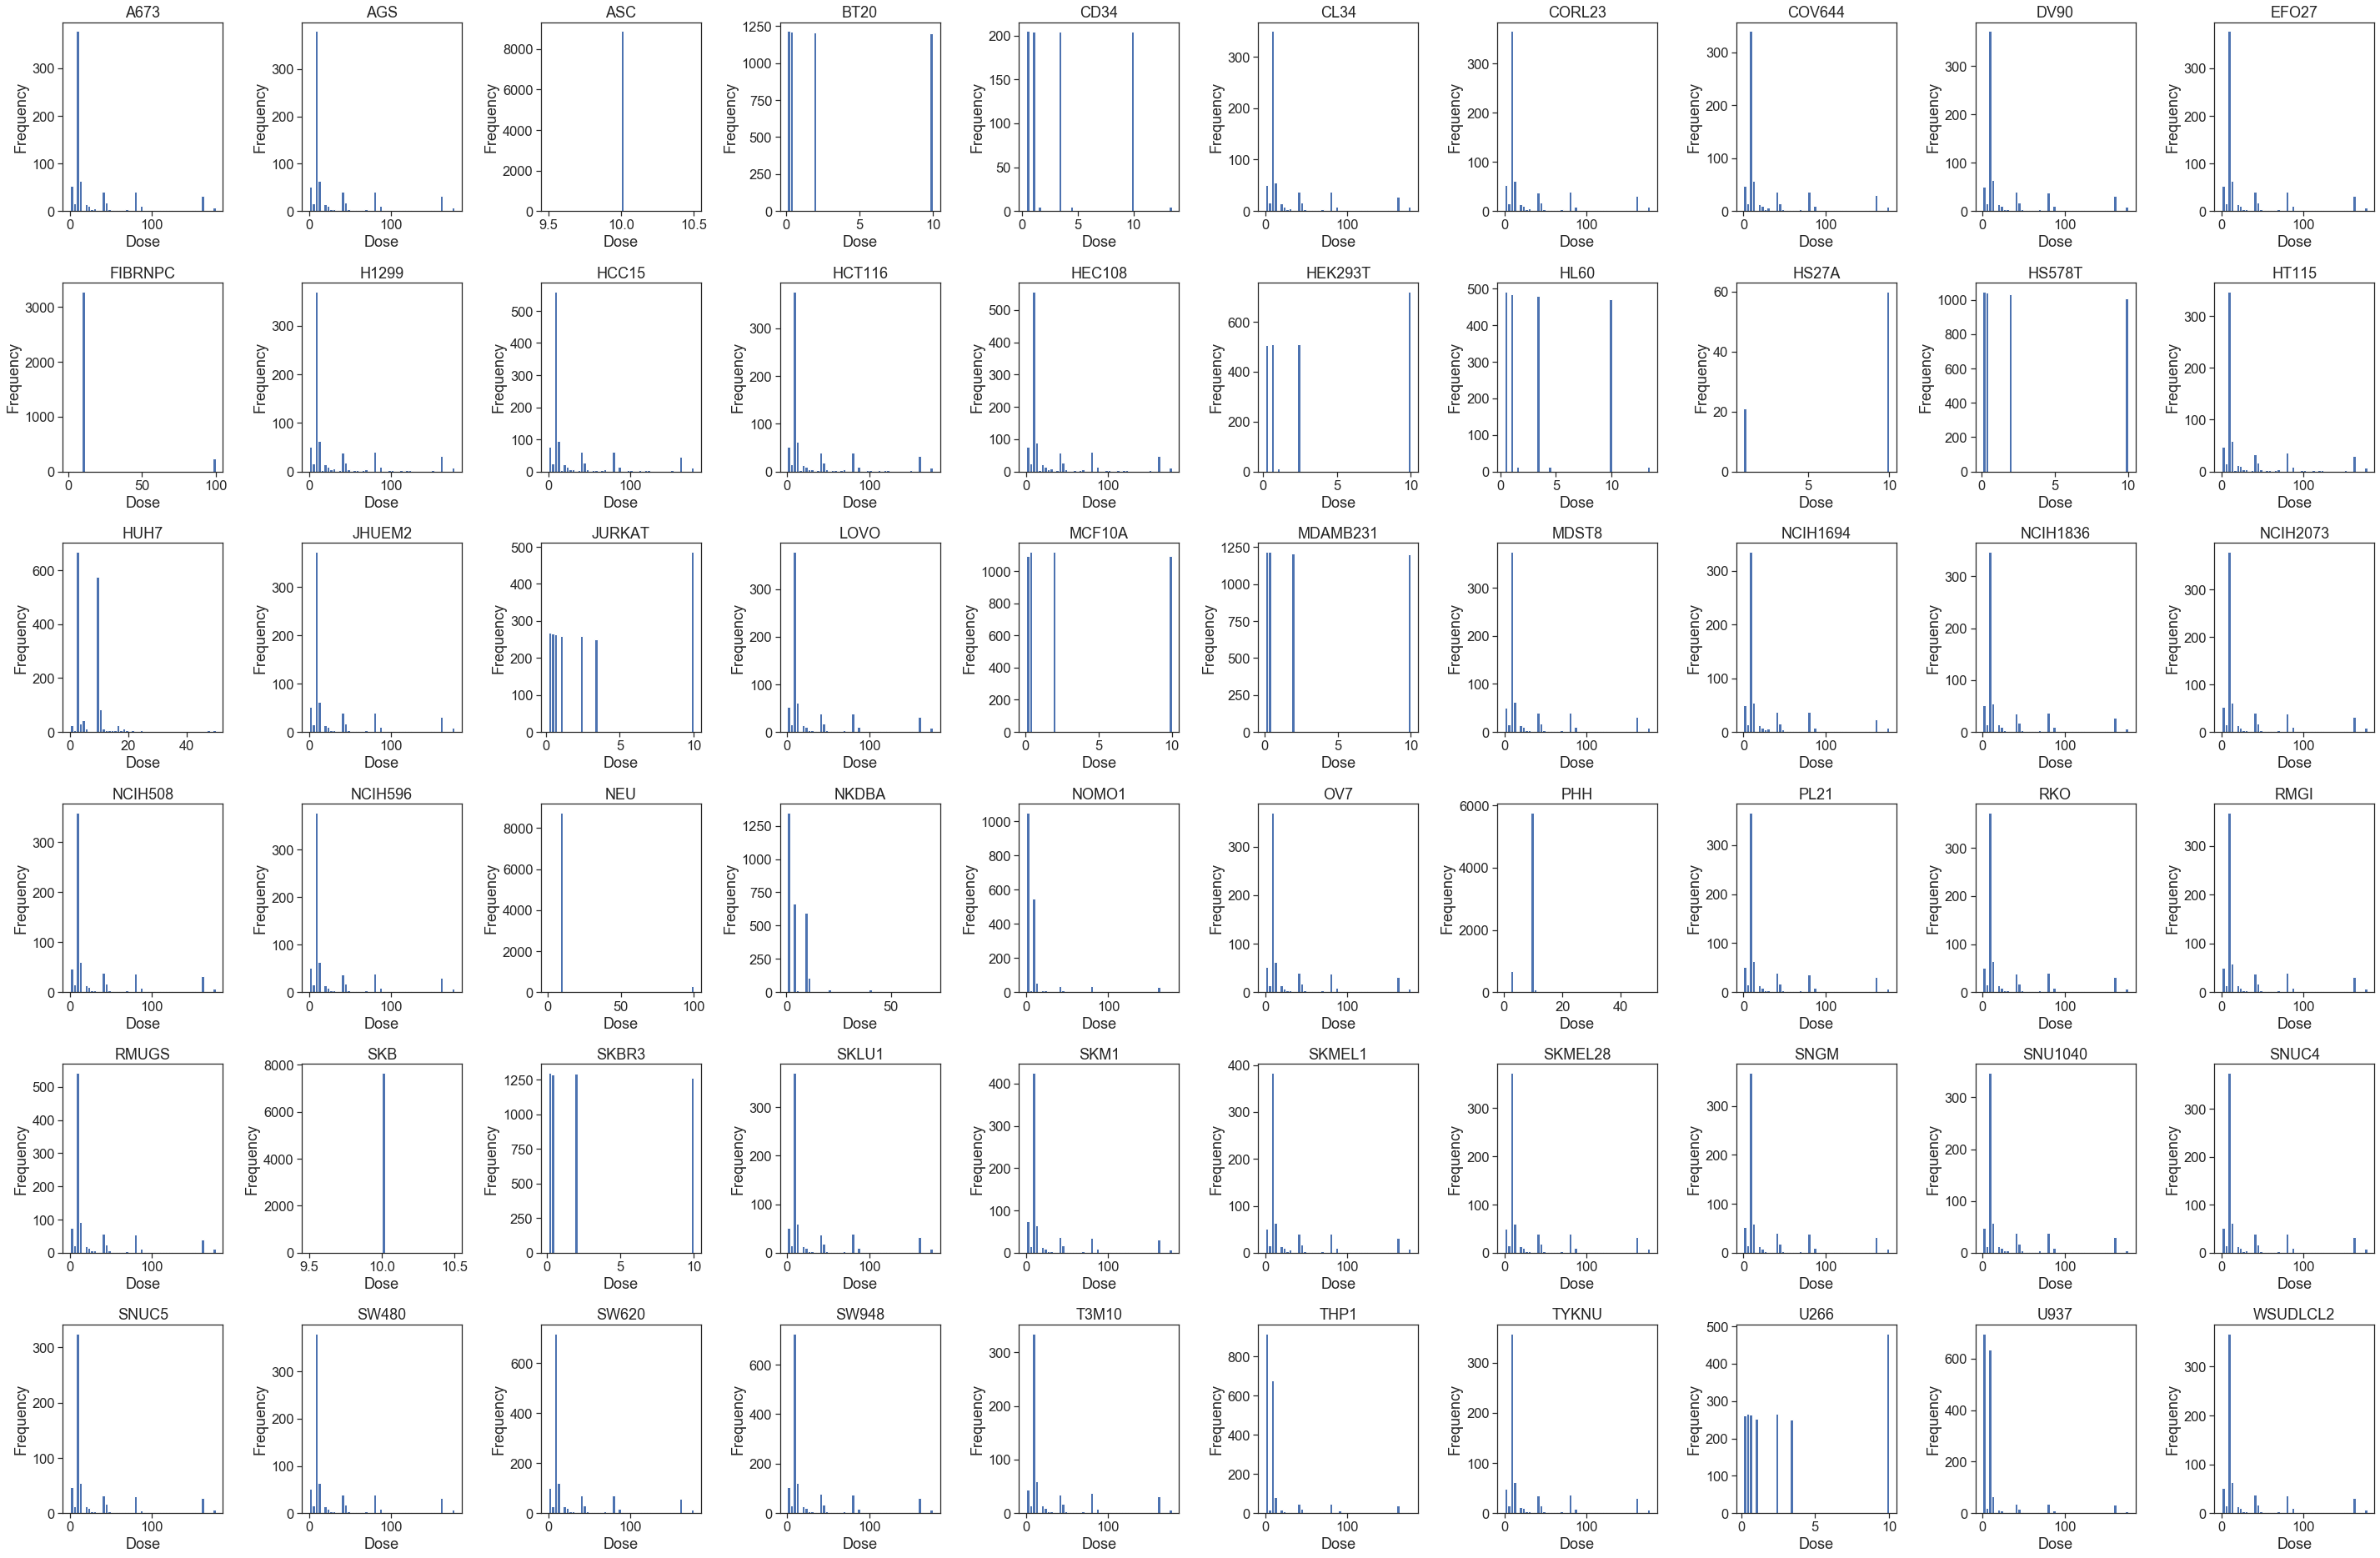

In [11]:
fig = plt.figure()
fig.set_size_inches(40, 30)
sns.set(font_scale=1.5)
with sns.axes_style('ticks'):
    for n, cell_type in enumerate(tqdm(sorted(list(set(QUIZC_allcells['Cell_type']) 
                                                   - set(['A375', 'A549', 'HA1E', 'HCC515', 'HEPG2', 'HT29', 'MCF7', 'NPC', 'PC3', 'VCAP']))), 
                                       position=0, leave=True)):
        
        level4 = pd.read_feather(rev_feather_path + 'Level4_all_parsed_%s.feather' % cell_type)
        level4_inst_info = pd.merge( L1000_inst_info, level4.set_index('rid').T.sort_index(), right_index=True, left_on='inst_id')
        level4_pert_iname = level4_inst_info.set_index('pert_iname')[level4['rid']]
        level4_pert_iname_z = ((level4_pert_iname - level4_pert_iname.mean(axis=0))) / level4_pert_iname.std(axis=0)
        level4_pert_iname_z = level4_pert_iname_z.reset_index()
        level4_pert_iname_z_grouped = level4_pert_iname_z.groupby('pert_iname')         
                
        plt.subplot(7, 10, n+1)  
        plt.hist(level4_inst_info['pert_dose'], bins=50)
        #plt.xlim(0, 10)
        #plt.xticks(np.arange(11))
        plt.xlabel('Dose')
        plt.ylabel('Frequency')
        plt.title(cell_type)
        plt.tight_layout()
        plt.savefig(proj_output_path + 'L1000_doses.pdf', format='pdf')
    plt.show()

## Correlation of the number of replicates and out-degree in gene-perturbagen networks

In [ ]:
inst_deg_corr_df = pd.DataFrame(index=['A375', 'A549', 'HA1E', 'HCC515', 'HEPG2', 'HT29', 'NPC'], columns=['QUIZ-C', 'MODZ', 'CD'])

for cell_type in tqdm(['A375', 'A549', 'HA1E', 'HCC515', 'HEPG2', 'HT29', 'NPC'], position=0, leave=True):

    level4 = pd.read_feather(rev_feather_path + 'Level4_all_parsed_%s.feather' % cell_type)
    level4_inst_info = pd.merge( L1000_inst_info, level4.set_index('rid').T.sort_index(), right_index=True, left_on='inst_id')
    level4_pert_iname = level4_inst_info.set_index('pert_iname')[level4['rid']]
    level4_pert_iname_z = ((level4_pert_iname - level4_pert_iname.mean(axis=0))) / level4_pert_iname.std(axis=0)
    level4_pert_iname_z = level4_pert_iname_z.reset_index()
    level4_pert_iname_z_grouped = level4_pert_iname_z.groupby('pert_iname')
    
    QUIZC_temp_inst_deg_df = pd.merge(pd.DataFrame(level4_pert_iname_z_grouped['pert_iname'].count()).rename(columns={'pert_iname': '# instances'}), 
                            pd.DataFrame(QUIZC_norm_out_degree_df[cell_type]).rename(columns={cell_type: 'norm_out_degree'}),
                            left_index=True, right_index=True, how='left')
    QUIZC_temp_inst_deg_df = QUIZC_temp_inst_deg_df.dropna()
    
    MODZ_temp_inst_deg_df = pd.merge(pd.DataFrame(level4_pert_iname_z_grouped['pert_iname'].count()).rename(columns={'pert_iname': '# instances'}), 
                                pd.DataFrame(MODZ_norm_out_degree_df[cell_type]).rename(columns={cell_type: 'norm_out_degree'}),
                                left_index=True, right_index=True, how='left')
    MODZ_temp_inst_deg_df = MODZ_temp_inst_deg_df.dropna()
    
    CD_temp_inst_deg_df = pd.merge(pd.DataFrame(level4_pert_iname_z_grouped['pert_iname'].count()).rename(columns={'pert_iname': '# instances'}), 
                                pd.DataFrame(CD_norm_out_degree_df[cell_type]).rename(columns={cell_type: 'norm_out_degree'}),
                                left_index=True, right_index=True, how='left')
    CD_temp_inst_deg_df = CD_temp_inst_deg_df.dropna()
    
    inst_deg_corr_df.at[cell_type, 'QUIZ-C'] = st.pearsonr(QUIZC_temp_inst_deg_df['norm_out_degree'], QUIZC_temp_inst_deg_df['# instances'])[0]
    inst_deg_corr_df.at[cell_type, 'MODZ'] = st.pearsonr(MODZ_temp_inst_deg_df['norm_out_degree'], MODZ_temp_inst_deg_df['# instances'])[0]
    inst_deg_corr_df.at[cell_type, 'CD'] = st.pearsonr(CD_temp_inst_deg_df['norm_out_degree'], CD_temp_inst_deg_df['# instances'])[0]
    
inst_deg_corr_df.to_csv(proj_output_path + 'inst_deg_corr_df.csv')

 14%|█▍        | 1/7 [02:56<17:38, 176.34s/it]

In [ ]:
inst_deg_corr_df = pd.DataFrame(index=sorted(list(set(MODZ_allcells['Cell_type']) - 
                                                  set(['A375', 'A549', 'HA1E', 'HCC515', 'HEPG2', 'HT29', 'MCF7', 'NPC', 'PC3', 'VCAP']))), 
                                columns=['QUIZ-C', 'MODZ', 'CD'])

for cell_type in tqdm(sorted(list(set(MODZ_allcells['Cell_type']) -
                                  set(['A375', 'A549', 'HA1E', 'HCC515', 'HEPG2', 'HT29', 'MCF7', 'NPC', 'PC3', 'VCAP']))), 
                      position=0, leave=True):

    level4 = pd.read_feather(rev_feather_path + 'Level4_all_parsed_%s.feather' % cell_type)
    level4_inst_info = pd.merge( L1000_inst_info, level4.set_index('rid').T.sort_index(), right_index=True, left_on='inst_id')
    level4_pert_iname = level4_inst_info.set_index('pert_iname')[level4['rid']]
    level4_pert_iname_z = ((level4_pert_iname - level4_pert_iname.mean(axis=0))) / level4_pert_iname.std(axis=0)
    level4_pert_iname_z = level4_pert_iname_z.reset_index()
    level4_pert_iname_z_grouped = level4_pert_iname_z.groupby('pert_iname')
    
    QUIZC_temp_inst_deg_df = pd.merge(pd.DataFrame(level4_pert_iname_z_grouped['pert_iname'].count()).rename(columns={'pert_iname': '# instances'}), 
                            pd.DataFrame(QUIZC_norm_out_degree_df[cell_type]).rename(columns={cell_type: 'norm_out_degree'}),
                            left_index=True, right_index=True, how='left')
    QUIZC_temp_inst_deg_df = QUIZC_temp_inst_deg_df.dropna()
    
    MODZ_temp_inst_deg_df = pd.merge(pd.DataFrame(level4_pert_iname_z_grouped['pert_iname'].count()).rename(columns={'pert_iname': '# instances'}), 
                                pd.DataFrame(MODZ_norm_out_degree_df[cell_type]).rename(columns={cell_type: 'norm_out_degree'}),
                                left_index=True, right_index=True, how='left')
    MODZ_temp_inst_deg_df = MODZ_temp_inst_deg_df.dropna()
    
    CD_temp_inst_deg_df = pd.merge(pd.DataFrame(level4_pert_iname_z_grouped['pert_iname'].count()).rename(columns={'pert_iname': '# instances'}), 
                                pd.DataFrame(CD_norm_out_degree_df[cell_type]).rename(columns={cell_type: 'norm_out_degree'}),
                                left_index=True, right_index=True, how='left')
    CD_temp_inst_deg_df = CD_temp_inst_deg_df.dropna()
    
    inst_deg_corr_df.at[cell_type, 'QUIZ-C'] = st.pearsonr(QUIZC_temp_inst_deg_df['norm_out_degree'], QUIZC_temp_inst_deg_df['# instances'])[0]
    inst_deg_corr_df.at[cell_type, 'MODZ'] = st.pearsonr(MODZ_temp_inst_deg_df['norm_out_degree'], MODZ_temp_inst_deg_df['# instances'])[0]
    inst_deg_corr_df.at[cell_type, 'CD'] = st.pearsonr(CD_temp_inst_deg_df['norm_out_degree'], CD_temp_inst_deg_df['# instances'])[0]
    
inst_deg_corr_df.to_csv(proj_output_path + 'inst_deg_corr_df_2.csv')